In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions, CocoDetection
from torchvision import transforms
from pycocotools import mask
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from datetime import datetime
import torch
from torch.utils import data
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class Dataset(CocoDetection):
    def __init__(self, root, annFile, transforms=None, transform=None, target_transform=None):
        super().__init__(root, annFile, transforms=None, transform=None, target_transform=None)
        
        cat_names = ['car',
                     'motorcycle',
                     'airplane',
                     'bus',
                     'train',
                     'truck',
                     'boat',
                    ]
        
        cats = self.coco.loadCats(self.coco.getCatIds(cat_names))
        
        ids = []
        self.id_to_class, self.class_to_name = dict(), dict()
        self.id_to_class[0] = 0
        self.class_to_name[0] = 'background'
        for it, cat in enumerate(cats):
            self.id_to_class[cat['id']] = it+1
            self.class_to_name[it+1] = cat['name']
            
            ids.append(self.coco.getImgIds(catIds=[cat['id']]))
            
        self.ids = sum(ids, [])

            
        self.transform = transform
            
    def num_classes(self):
        return len(self.id_to_class)
        
    def __getitem__(self, index):

        img, ann = super().__getitem__(index)
        width, height = img.size[:2]

        msk = np.zeros((height, width), dtype=np.uint8)
        for i, it in enumerate(ann):
            if it['category_id'] in self.id_to_class.keys():
                compressed_rle = mask.frPyObjects(it['segmentation'], height, width)
                bw = mask.decode(compressed_rle)

                if len(bw.shape) == 3:
                    bw = np.sum(bw, axis=2)

                msk[np.where(bw != 0)] = self.id_to_class[it['category_id']]
        
        msk = Image.fromarray(msk)
        
        img = img.resize((224,224), resample=2)
        msk = msk.resize((224,224))
        
        img = np.float32(np.array(img)) / 255.
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img.copy())
        
        msk = torch.from_numpy(np.array(msk)).long()

        return img, msk

In [10]:
train_dataset = Dataset('/home/vasily/datasets/COCO/images/train2017', '/home/vasily/datasets/COCO/annotations/instances_train2017.json')

loading annotations into memory...
Done (t=13.68s)
creating index...
index created!


In [16]:
img, msk = train_dataset[20]

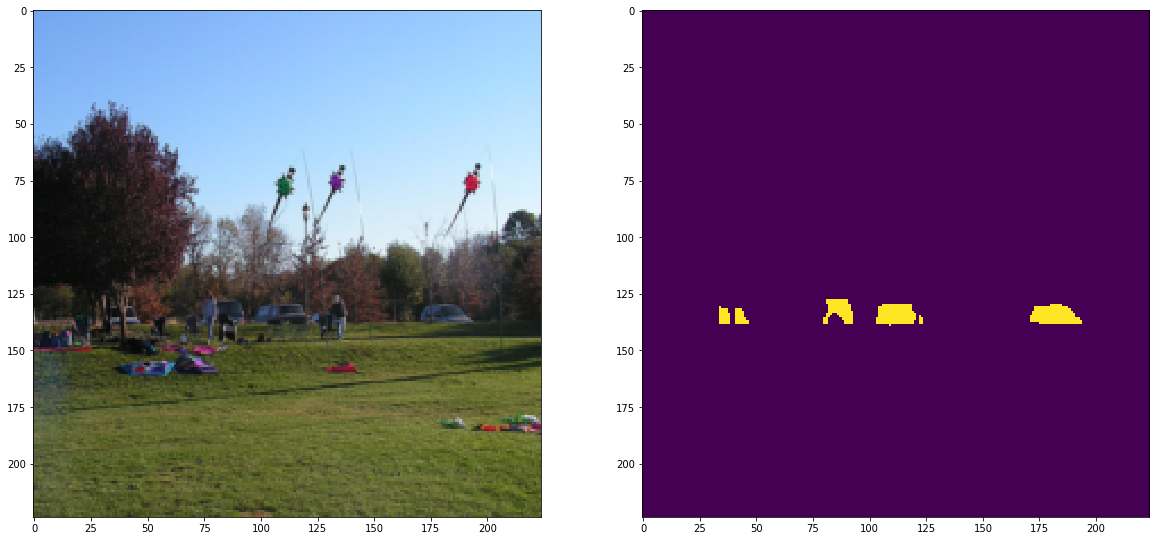

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img.numpy().transpose((1,2,0)))
plt.subplot(122)
plt.imshow(np.squeeze(msk.numpy()))
# plt.imshow(np.squeeze(msk.numpy().transpose((1,2,0))))

In [18]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)

In [23]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [26]:
from torch import nn

model = smp.Unet(classes=train_dataset.num_classes(), activation='softmax').to(device)
# loss = smp.utils.losses.BCEDiceLoss(activation='softmax')
# criterion = nn.NLLLoss(ignore_index=-1)
criterion = nn.CrossEntropyLoss()
criterion.__name__= 'loss'


def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc

metrics = [
    smp.utils.metrics.IoUMetric(eps=1., activation='softmax'),
#     smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

In [ ]:
average_total_loss = AverageMeter()
average_acc = AverageMeter()

for epoch in range(3):   
    start=datetime.now()
    for i, data in enumerate(train_loader):
#         if i != 0 and i % 10 == 0: # too big dataset
#             break
        torch.cuda.empty_cache()
        inputs, masks = data
        
        inputs=inputs.to(device)
        masks=masks.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
#         loss = criterion(torch.argmax(outputs, dim=1).unsqueeze(1).cpu().float(), masks.float()) #BCEWithLogitsLoss
        loss = criterion(outputs, masks) #CrossEntropyLoss 
        acc = pixel_acc(outputs, masks)
#         loss = criterion(outputs, labels) #IoU
        loss.backward()
        optimizer.step()
        
        average_total_loss.update(loss.data.item())
        average_acc.update(acc.data.item())

        if (i + 1) % 100 == 0:
            print('[%s] [epoch %d]\t[iter %d / %d]\t[train loss %.5f]\t[accuracy %.3f]' % (
                datetime.now()-start, epoch, i + 1, len(train_loader), average_total_loss.average(), average_acc.average()
            ))
            start=datetime.now()

[0:00:11.109402] [epoch 0]	[iter 100 / 4429]	[train loss 1.34804]	[accuracy 0.619]
[0:00:11.016593] [epoch 0]	[iter 200 / 4429]	[train loss 1.18693]	[accuracy 0.695]
[0:00:10.931501] [epoch 0]	[iter 300 / 4429]	[train loss 1.09069]	[accuracy 0.732]
[0:00:11.281763] [epoch 0]	[iter 400 / 4429]	[train loss 1.02608]	[accuracy 0.758]
[0:00:11.060832] [epoch 0]	[iter 500 / 4429]	[train loss 0.97557]	[accuracy 0.775]
[0:00:10.958140] [epoch 0]	[iter 600 / 4429]	[train loss 0.93180]	[accuracy 0.789]
[0:00:11.296555] [epoch 0]	[iter 700 / 4429]	[train loss 0.89323]	[accuracy 0.800]
[0:00:10.988987] [epoch 0]	[iter 800 / 4429]	[train loss 0.85932]	[accuracy 0.809]
[0:00:11.100483] [epoch 0]	[iter 900 / 4429]	[train loss 0.82899]	[accuracy 0.817]
[0:00:11.324707] [epoch 0]	[iter 1000 / 4429]	[train loss 0.80256]	[accuracy 0.823]
[0:00:11.162621] [epoch 0]	[iter 1100 / 4429]	[train loss 0.77943]	[accuracy 0.828]
[0:00:10.978787] [epoch 0]	[iter 1200 / 4429]	[train loss 0.75724]	[accuracy 0.833]
[

In [20]:
img, msk = train_dataset[101]

In [54]:
sm = nn.Softmax(dim=1)
pred = sm(model(img.expand(1, -1,-1,-1).to(device)))

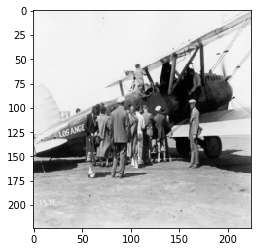

In [55]:
plt.imshow(img.numpy().transpose((1,2,0)))

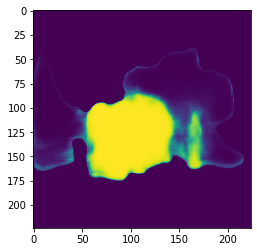

In [57]:
plt.imshow(pred[0][1].detach().cpu().numpy())

In [66]:
def pixel_acc(pred, label):
        _, preds = torch.max(pred, dim=1)
        valid = (label >= 0).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        return acc

pixel_acc(pred.cpu(), msk)

tensor(0.7011)

In [43]:
train_dataset.class_to_name

{0: 'background',
 1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'stop sign',
 13: 'parking meter',
 14: 'bench',
 15: 'bird',
 16: 'cat',
 17: 'dog',
 18: 'horse',
 19: 'sheep',
 20: 'cow',
 21: 'elephant',
 22: 'bear',
 23: 'zebra',
 24: 'giraffe',
 25: 'backpack',
 26: 'umbrella',
 27: 'handbag',
 28: 'tie',
 29: 'suitcase',
 30: 'frisbee',
 31: 'skis',
 32: 'snowboard',
 33: 'sports ball',
 34: 'kite',
 35: 'baseball bat',
 36: 'baseball glove',
 37: 'skateboard',
 38: 'surfboard',
 39: 'tennis racket',
 40: 'bottle',
 41: 'wine glass',
 42: 'cup',
 43: 'fork',
 44: 'knife',
 45: 'spoon',
 46: 'bowl',
 47: 'banana',
 48: 'apple',
 49: 'sandwich',
 50: 'orange',
 51: 'broccoli',
 52: 'carrot',
 53: 'hot dog',
 54: 'pizza',
 55: 'donut',
 56: 'cake',
 57: 'chair',
 58: 'couch',
 59: 'potted plant',
 60: 'bed',
 61: 'dining table',
 62: 'toilet',
 63: 'tv',
 64: 